<a href="https://www.kaggle.com/code/fortuneuwha/super-soaker-predicting-product-failures?scriptVersionId=120450290" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<center><h1>Predict product failures</h1></center>
<center><h4>Synthetic data from a fictional company "Keep It Dry"</h4></center>


## 🔵 Background
The August 2022 edition of the Tabular Playground Series is focusing on helping the fictional company Keep It Dry improve its main product Super Soaker. The product is used in factories to absorb spills and leaks. 

The company has just completed a large testing study for different product prototypes. We would be using the available data to build a model that predicts product failures.


In [1]:
# Run this to enable CSS stype
# WARNING: run it in a separate cell, not alongside other code blocks too
from IPython.core.display import HTML
def css_styling():
    styles = open('../input/alert-css/alerts.css', "r").read()
    return HTML("<style>"+styles+"</style>")
css_styling()

#### 📤Import Libraries

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_auc_score, auc, classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("../input/tabular-playground-series-aug-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-aug-2022/test.csv")
all_features = pd.concat([test,train]).reset_index(drop=True)
all_features.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612,NaN
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037,NaN
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995,NaN
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301,NaN
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044,NaN


### 🧭**Data Exploration**

Like a magnetic compass is used for navigation, EDA is a crucial step before working on a dataset for navigating, that is, finding our way and understanding the data and the problem at hand.

In this project, to better understand the data we are working with, and to gain insight into their relationships, we will explore our target variable and how the other features influence it.

But first, we can start analysis by looking at the percentage of missing values in each column. Below is a function that calculates the number of missing values and the percentage of the total values that are missing for each column.

In [4]:
def missing_values_table(data):
        # Total missing values
        mis_val = data.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * data.isnull().sum() / len(data)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(data.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
missing_values_table(train)


Your selected dataframe has 26 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
measurement_17,2284,8.6
measurement_16,2110,7.9
measurement_15,2009,7.6
measurement_14,1874,7.1
measurement_13,1774,6.7
measurement_12,1601,6.0
measurement_11,1468,5.5
measurement_10,1300,4.9
measurement_9,1227,4.6
measurement_8,1048,3.9


In [6]:
missing_values_table(test)

Your selected dataframe has 25 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
measurement_17,1740,8.4
measurement_16,1678,8.1
measurement_15,1542,7.4
measurement_14,1440,6.9
measurement_13,1303,6.3
measurement_12,1240,6.0
measurement_11,1136,5.5
measurement_10,1067,5.1
measurement_9,904,4.4
measurement_8,846,4.1


### Balanced or Imbalanced data? 

Let's find out

0.0    20921
1.0     5649
Name: failure, dtype: int64


<AxesSubplot:>

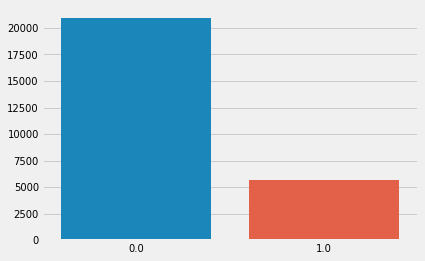

In [7]:
y = all_features['failure'].value_counts()
print(y)
sns.barplot(y.index, y.values)

<div class="alert simple-alert">
  <p>💡<b>Note</b>: clearly, we have a class imbalance</p>
</div>

### Data preprocessing 🧹

In [8]:
#Encoding the target variabe
train["failure"] = LabelEncoder().fit_transform(train["failure"])

In [9]:
train["attribute_0"] = LabelEncoder().fit_transform(train["attribute_0"])
test["attribute_0"] = LabelEncoder().fit_transform(test["attribute_0"])

train["attribute_1"] = LabelEncoder().fit_transform(train["attribute_1"])
test["attribute_1"] = LabelEncoder().fit_transform(test["attribute_1"])

train["product_code"] = LabelEncoder().fit_transform(train["product_code"])
test["product_code"] = LabelEncoder().fit_transform(test["product_code"])

In [10]:
features = train.columns.drop(['id', 'failure'])
X = pd.get_dummies(train[features])
y = train['failure']
test = pd.get_dummies(test[features])

## Model Building I
### 🧱 Split Into Training and Testing Sets
In machine learning, we always need to separate our features into two sets:

1. Training set which we provide to our model during training along with the answers so it can learn a mapping between the features and the target.
2. Testing set which we use to evaluate the mapping learned by the model. The model has never seen the answers on the testing set, but instead, must make predictions using only the features. As we know the true answers for the test set, we can then compare the test predictions to the true test targets to get an estimate of how well our model will perform when deployed in the real world.

For our problem, we will split the data into 80% training set and 20% for testing.Let's do this!

Splitting the data into a random training and testing set is simple using scikit-learn. We can set the random state of the split to ensure consistent results.

In [11]:
#Create train and test split sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
X_train.shape, X_test.shape

((21256, 24), (5314, 24))

Now let's create some custom functions to calculate the model's ROC-AUC score. To avoid overfitting the data, we will compare the model's prediction for the 20% test data to the actual test data for this project. Stay with me please,we are getting to the fun part😁

In [12]:
def model_auc_score(model):
    train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f'Train AUC Score: {train_auc}, Test AUC Score: {test_auc}')

Below is a custom function to always plot the confusion matrix and roc curve of the model. Visuals they say, give answers to questions we didn't know we had. So why not paint a picture of our model?

In [13]:
def plot(model):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    plot_confusion_matrix(model, X_test, y_test, ax=ax[0], display_labels=["0", "1"], cmap='Blues')
    plot_roc_curve(model,X_test, y_test, ax=ax[1])
    ax[0].set(title='Confusion Matrix')
    ax[1].set(title='ROC Curve')
    ax[0].grid(False)
    ax[1].grid(False)
    ax[1].legend(loc='center right')
    plt.tight_layout(pad=1.0)

## Model Building II
We will be using different variations of gradient boosting

### Model 1 - Extreme Gradient Boosting( XGBoost)
First to get the best parameters to use for this, we will use the `RandomizedSearchCV` object

In [14]:
# Instantiate the classifier: xgb
import xgboost as xgb
clf_xgb = xgb.XGBClassifier()
#Set up the sample space
n_estimators_list = [50,100, 200, 300, 400, 500]
learning_rate_list = [0.0001, 0.001, 0.01, 0.1]

# Create the parameter distribution: xgb_param_dist
xgb_param_dist = {
    'learning_rate':learning_rate_list,
    'colsample_bytree': [0.1, 0.3,0.5,0.7],
    'n_estimators': n_estimators_list,
    'max_depth': [2,5,6,7]}
str_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# Perform Random search: random_auc
random_search = RandomizedSearchCV(estimator=clf_xgb, param_distributions=xgb_param_dist,n_jobs=4,scoring='roc_auc',cv=str_kf,verbose=1)
random_result = random_search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [15]:
print(f"Best: {random_result.best_score_} using {random_result.best_params_}")
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Best: 0.5810849573556709 using {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0001, 'colsample_bytree': 0.7}


In [16]:
import xgboost as xgb
from sklearn.metrics import log_loss
pred_score_xgb = []
test_pred_xgb = []
splits = None
str_kf = StratifiedKFold(n_splits = 5,shuffle=True,random_state=6758)

for train_index,test_index in str_kf.split(X,y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    clf_xgb = xgb.XGBClassifier(objective='binary:logistic',n_estimators = 200,max_depth= 5, learning_rate= 0.001, colsample_bytree= 0.3,seed=980)
    clf_xgb.fit(X_train,y_train, eval_set=[(X_train,y_train),(X_test,y_test)],
           early_stopping_rounds=100,verbose=True)
    
    pred_score_xgb = clf_xgb.predict_proba(X_test)[:,1]
    
    print('Logloss:', log_loss(y_test,pred_score_xgb),'*'*30)
    
    test_xgb = clf_xgb.predict_proba(test[X.columns])[:,1]
    
    test_pred_xgb.append(test_xgb)

[0]	validation_0-logloss:0.69280	validation_1-logloss:0.69281
[1]	validation_0-logloss:0.69247	validation_1-logloss:0.69248
[2]	validation_0-logloss:0.69214	validation_1-logloss:0.69215
[3]	validation_0-logloss:0.69180	validation_1-logloss:0.69182
[4]	validation_0-logloss:0.69147	validation_1-logloss:0.69149
[5]	validation_0-logloss:0.69114	validation_1-logloss:0.69117
[6]	validation_0-logloss:0.69081	validation_1-logloss:0.69084
[7]	validation_0-logloss:0.69046	validation_1-logloss:0.69051
[8]	validation_0-logloss:0.69012	validation_1-logloss:0.69017
[9]	validation_0-logloss:0.68980	validation_1-logloss:0.68984
[10]	validation_0-logloss:0.68947	validation_1-logloss:0.68952
[11]	validation_0-logloss:0.68914	validation_1-logloss:0.68920
[12]	validation_0-logloss:0.68881	validation_1-logloss:0.68888
[13]	validation_0-logloss:0.68848	validation_1-logloss:0.68856
[14]	validation_0-logloss:0.68815	validation_1-logloss:0.68823
[15]	validation_0-logloss:0.68782	validation_1-logloss:0.68791
[1

In [17]:
model_auc_score(clf_xgb)

Train AUC Score: 0.6816687815083546, Test AUC Score: 0.5676555440870403


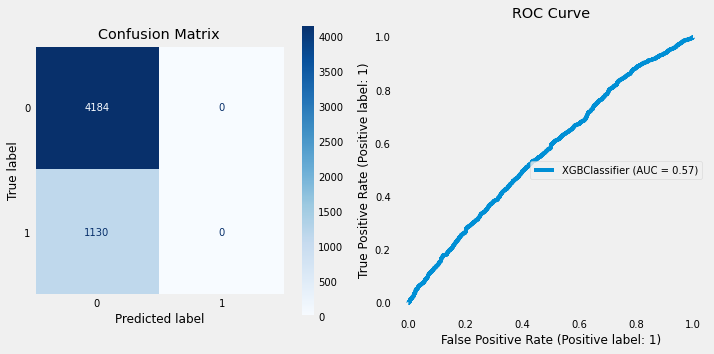

In [18]:
plot(clf_xgb)

In [19]:
predictions_xgb = np.mean(test_pred_xgb, axis=0) + np.std(test_pred_xgb, axis=0)
predictions_xgb

array([0.44747046, 0.4462232 , 0.4466293 , ..., 0.4470094 , 0.44766718,
       0.4432951 ], dtype=float32)

In [20]:
print(classification_report(y_test,clf_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      4184
           1       0.00      0.00      0.00      1130

    accuracy                           0.79      5314
   macro avg       0.39      0.50      0.44      5314
weighted avg       0.62      0.79      0.69      5314



#### Model 2 - Light Gradient Boosting Machine(LightGBM)⚡

<div class="alert simple-alert">
  <p>💡<b>LightGBM</b>: This is faster in training, more efficient and lighter in terms of space. In addition it handles missing values in its own way just like xgboost. How it handles missing values is a topic for another project. Time to try it😁</p>
</div>

In [21]:
import lightgbm as lgb
pred_score_lgb = []
test_pred_lgb = []
splits = None
str_kf = StratifiedKFold(n_splits = 5,shuffle=True,random_state=8091)

for train_index,test_index in str_kf.split(X,y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    clf_lgb = lgb.LGBMClassifier(silent=True,random_state= 1091)
    clf_lgb.fit(X_train,y_train, eval_set=[(X_train,y_train),(X_test,y_test)],
           early_stopping_rounds=100, eval_metric='AUC',verbose=True)
    
    pred_score_lgb = clf_lgb.predict_proba(X_test)[:,1]
    
    print('Logloss:', log_loss(y_test,pred_score_lgb),'*'*30)
    
    test_lgb = clf_lgb.predict_proba(test[X.columns])[:,1]
    
    test_pred_lgb.append(test_lgb)

[1]	training's auc: 0.610947	training's binary_logloss: 0.514244	valid_1's auc: 0.584737	valid_1's binary_logloss: 0.514999
[2]	training's auc: 0.618915	training's binary_logloss: 0.511503	valid_1's auc: 0.58843	valid_1's binary_logloss: 0.513619
[3]	training's auc: 0.622035	training's binary_logloss: 0.509201	valid_1's auc: 0.58847	valid_1's binary_logloss: 0.512418
[4]	training's auc: 0.635968	training's binary_logloss: 0.507133	valid_1's auc: 0.587635	valid_1's binary_logloss: 0.511755
[5]	training's auc: 0.639208	training's binary_logloss: 0.505352	valid_1's auc: 0.588862	valid_1's binary_logloss: 0.511114
[6]	training's auc: 0.649107	training's binary_logloss: 0.503603	valid_1's auc: 0.585619	valid_1's binary_logloss: 0.510797
[7]	training's auc: 0.654756	training's binary_logloss: 0.501924	valid_1's auc: 0.588316	valid_1's binary_logloss: 0.51018
[8]	training's auc: 0.655947	training's binary_logloss: 0.500308	valid_1's auc: 0.587795	valid_1's binary_logloss: 0.509724
[9]	trainin

<div class="alert success-alert">
  <p>💡Now that was fast!. Let's see how well it performs</p>
</div>

In [22]:
model_auc_score(clf_lgb)

Train AUC Score: 0.8873205658533909, Test AUC Score: 0.5448243625103639


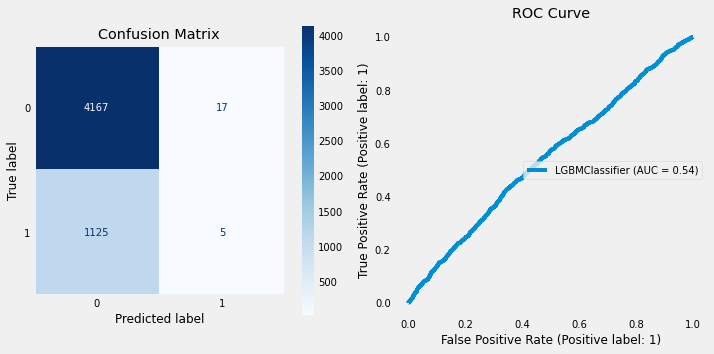

In [23]:
plot(clf_lgb)

`Overall Validation Prediction`

In [24]:
predictions_lgb = np.mean(test_pred_lgb, axis=0) + np.std(test_pred_lgb, axis=0)
predictions_lgb

array([0.29016195, 0.17878821, 0.18574558, ..., 0.16112539, 0.24721695,
       0.13045332])

In [25]:
print(classification_report(y_test,clf_lgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      4184
           1       0.23      0.00      0.01      1130

    accuracy                           0.79      5314
   macro avg       0.51      0.50      0.44      5314
weighted avg       0.67      0.79      0.69      5314



### Submission - All models ensemble!
When you want to purchase a new car, will you walk up to the first car shop and purchase one based on the advice of the dealer? It’s highly unlikely.

You would likely browser a few web portals where people have posted their reviews and compare different car models, checking for their features and prices. You will also probably ask your friends and colleagues for their opinion. In short, you wouldn’t directly reach a conclusion, but will instead make a decision considering the opinions of other people as well.

Ensemble models in machine learning operate on a similar idea. They combine the decisions from multiple models to improve the overall performance. This can be achieved in various ways, but in this model though we will be using the Weighted Average

### Weighted Average
All models are assigned different weights defining the importance of each model for prediction. For instance, if two of your colleagues are critics, while others have no prior experience in this field, then the answers by these two friends are given more importance as compared to the other people. Let's do the same for our models

In [26]:
sub = pd.read_csv('../input/tabular-playground-series-aug-2022/sample_submission.csv')

In [27]:
sub_xgb = pd.DataFrame()
sub_xgb["failure"] = predictions_xgb

sub_lgb = pd.DataFrame()
sub_lgb["failure"] = predictions_lgb

sub["failure"] = (sub_xgb["failure"] * 0.3+sub_lgb["failure"] * 0.7)

In [28]:
print(sub.head())
sub.to_csv('sub_xgb_lgb.csv', index=False)

      id   failure
0  26570  0.337355
1  26571  0.259019
2  26572  0.264011
3  26573  0.264112
4  26574  0.334798


<div class="alert warning-alert">
  <p>💡HUGE thanks to Andrada Olteanu for creating a <a href="https://www.kaggle.com/code/andradaolteanu/hidden-gems-specialsauces-to-create-amazing-eda"> stylish notebook filled with gems.</a> Learnt a lot of tips and tricks to style your kaggle notebook. Check it out if you can and upvote😁 </p>
</div>

## ⏳Work in progress